# Exploring Metadata Keyword Relationships with word2vec

This notebook demonstrates using a pretrained word2vec model to explore how keywords are related to other words and other keywords. 

Examples of how to use pretrained models and code where used from https://github.com/3Top/word2vec-api


This notebook runs on the docker jupyter/datascience-notebook container with gensim additionally installed as below 

In [75]:
%matplotlib inline

In [2]:
%%bash
pip install gensim

  Running setup.py bdist_wheel for smart-open: started
  Running setup.py bdist_wheel for smart-open: finished with status 'done'
  Stored in directory: /home/jovyan/.cache/pip/wheels/5f/ea/fb/5b1a947b369724063b2617011f1540c44eb00e28c3d2ca8692
Successfully built smart-open


You are using pip version 9.0.3, however version 19.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
from gensim.models.word2vec import Word2Vec as w
import gensim.models
from gensim import utils, matutils

## Loading a pretrained word2vec model

This model has been sourced http://nlp.stanford.edu/data/glove.6B.zip to use this you'll need to download it as it's too big to package alongside this notebook.

To load it sucessfully it has been modified to add a '400000 300' (presumably specifying the number of words and vector size) to a new line above the rest of the data

In [ ]:
%%bash
wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
%%bash
unzip -o 'glove.6B.zip'

In [11]:
%%bash
sed -i '1s/^/400000 300\n/' glove.6B.300d.txt

In [ ]:
%%bash 
head -2 ./glove.6B.300d.txt

In [16]:
import gensim

In [17]:
model = gensim.models.KeyedVectors.load_word2vec_format('./glove.6B.300d.txt', binary=False)

## Keywords describing datasets

A keywords.json file was produced from backend data harvested as part of populating the knowledge network http://kn.csiro.au

In [18]:
import json

In [19]:
with open('./keywords.json') as keywords_json_file:
    raw_keywords = json.load(keywords_json_file)

### Lots of datasets but only a few of them have keywords

In [20]:
keywords_dict = [keyword for keyword in raw_keywords if 'keywords' in keyword.keys() and keyword['keywords'] != None]

In [23]:
print(len(raw_keywords))
print(len(keywords_dict))

67695
1822


In [24]:
import pandas as pd
pd.set_option('max_colwidth', 1000)

df = pd.DataFrame.from_dict(keywords_dict)
df[0:10]

,_id,keywords
0,59159e9b3dd97b0a4c165378,"[entomology, insects, spiders, fauna]"
1,59159e9b3dd97b0a4c165379,[plants]
2,59159e9b3dd97b0a4c16537b,[microbial]
3,59159e9b3dd97b0a4c16537e,[plants]
4,59159e9b3dd97b0a4c16537f,"[herbarium, herbaria, angiosperms, dicots, monocots, pteridophytes, mosses, liverworts, lichens, fungi, algae, plants]"
5,59159e9b3dd97b0a4c165380,[microbial]
6,59159e9b3dd97b0a4c165381,[microbial]
7,59159e9b3dd97b0a4c165382,[microbes]
8,59159e9b3dd97b0a4c165383,"[arachnids, spiders, myriapods, centipedes, millipedes, onychophorans, ""velvet, worms"", tardigrades, ""water, bears"", fauna]"
9,59159e9b3dd97b0a4c165384,"[entomology, insects, hexapoda]"


## Keyword cleaning and considerations

Keywords are flattened to a unique list. However there are a lot of keywords that aren't single words. These aren't handled currently. 

In [25]:
flat_keywords = [keyword.lower() for keyword_item in keywords_dict for keyword in keyword_item['keywords']]

In [26]:
unique_keywords = list(set(flat_keywords))

In [27]:
len(unique_keywords)

1812

In [ ]:
## Finding similar words

Here we find the top 10 words similar to a keyword. Note that this isn't finding the most similar other keywords rather it is finding words from the original word to vec corpus (in this case wikipedia + gigawords), only a small number of which are exisiting keywords. Also note that not all keywords are in the corpus if a keyword isn't present an error is thrown.

In [30]:
unique_keywords[1:30]

['cattle',
 'cloud reflectance',
 'mgoh group content',
 'biofilm',
 'nipah virus',
 'flinders catchment',
 'climex',
 'soil attributes',
 'air humidity, plant',
 'atmosphere winds',
 'economic',
 'pharmacokinetic',
 'eukaryotes',
 'tropical pastures',
 'image analysis, cdna microarray analysis',
 'bromoform ',
 'biodiversity, generalised vegetation patterns',
 'wireless sensor network',
 'vegetation',
 'wind, direction, lansdown, sensor',
 'wave period',
 'asparagus asparagoides',
 'gear trials: in2015_e01',
 'lauraceae',
 'data-constrained modelling, x-ray ct, carbonate, calcite, dolomite, oil &amp',
 'humus',
 'aspect',
 'pipeline',
 'flower']

In [31]:
model.most_similar_cosmul(positive='flower',topn=10)

[('flowers', 0.850063681602478),
 ('petals', 0.7753748893737793),
 ('floral', 0.7735286355018616),
 ('blossoms', 0.7563701272010803),
 ('fruit', 0.7506299018859863),
 ('flowering', 0.7505371570587158),
 ('roses', 0.7504088282585144),
 ('buds', 0.745373010635376),
 ('blooms', 0.7371509671211243),
 ('lavender', 0.7359495162963867)]

In [38]:
keyword_similarities = {}
for keyword in unique_keywords[1:30]:
    try:
        keyword_similarities[keyword[0:20]] = model.most_similar_cosmul(positive=keyword,topn=10)
    except:
        keyword_similarities[keyword[0:20]] = ["Word Not Found"]
        continue
#print(keyword_similarities)
pd.DataFrame.from_dict(keyword_similarities, orient="index")

,0,1,2,3,4,5,6,7,8,9
cattle,"(livestock, 0.8918353915214539)","(sheep, 0.8761770725250244)","(cows, 0.8659452199935913)","(herds, 0.8254205584526062)","(cow, 0.8124057650566101)","(herd, 0.8111633658409119)","(goats, 0.8096607327461243)","(pigs, 0.7950717210769653)","(hogs, 0.7912872433662415)","(ranchers, 0.7834054231643677)"
cloud reflectance,Word Not Found,None,None,None,None,None,None,None,None,None
mgoh group content,Word Not Found,None,None,None,None,None,None,None,None,None
biofilm,"(biofilms, 0.7793806791305542)","(microbial, 0.7168845534324646)","(tumorigenesis, 0.711588442325592)","(overgrowth, 0.7092530727386475)","(microorganisms, 0.7048378586769104)","(phototrophic, 0.7012143731117249)","(filamentous, 0.7011398077011108)","(bacterial, 0.700860857963562)","(gingivitis, 0.696479082107544)","(epithelial, 0.6950613260269165)"
nipah virus,Word Not Found,None,None,None,None,None,None,None,None,None
flinders catchment,Word Not Found,None,None,None,None,None,None,None,None,None
climex,Word Not Found,None,None,None,None,None,None,None,None,None
soil attributes,Word Not Found,None,None,None,None,None,None,None,None,None
"air humidity, plant",Word Not Found,None,None,None,None,None,None,None,None,None
atmosphere winds,Word Not Found,None,None,None,None,None,None,None,None,None


## Finding only similar existing keywords

In some use cases we might want to only want to find existing keywords similar to other keywords. This might help a user select a new keyword based on other similar keywords to an already selected keyword. The best way to do this might be to reset the word2vec model to use the keywords as a corpus and then "copy" the weights from an existing model (because we can't easily train specifically on the small keyword corpus). An alternative is to "brute force" this by build ordered dictionaries so that each keyword is associated with an list of all other keywords ordered by similarity. Not implemented yet but might begin like the following

In [46]:
print('Source Keyword: ocean' + '\n')
results_similarity = {}
for keyword in unique_keywords:
    try:
        results_similarity[keyword] = str(model.similarity(keyword, 'ocean'))
    except:
        pass
df = pd.DataFrame()
df['Keyword'] = results_similarity.keys()
df['Similarity Score'] = results_similarity.values()
df.sort_values(by=['Similarity Score'], ascending=False)


Source Keyword: ocean



,Keyword,Similarity Score
375,ocean,1.0
535,sea,0.684473
297,oceans,0.643771
451,coast,0.577876
360,coastal,0.544094
186,waves,0.497618
214,tidal,0.478499
72,water,0.476902
18,reefs,0.457699
595,tropical,0.44709


## What else might we be able to do with word2vec vectors and keywords

One thing that might be possible is to look at how closely related a particular set of keywords attributed to a dataset  actually are. We can compare word vector distance ourselves and so can calculate average distance of keywords with each other. 

In [47]:
model.word_vec('sea')

array([ 0.29919001, -0.11731   , -0.0089925 , -0.37059   , -0.06722   ,
        0.15163   , -0.061105  ,  0.29587001,  0.36515999, -1.50870001,
        0.46160001, -0.15762   ,  0.015131  ,  0.31378999,  0.49033999,
        0.23762   ,  0.27667001,  0.44819999, -0.64633   ,  0.66012001,
       -0.65131003,  0.36984   , -0.41850001, -0.053622  , -0.0097837 ,
       -0.12772   ,  0.47055   ,  0.65263999, -0.37119001,  0.48045999,
        0.39286   , -0.06189   , -0.88924998, -0.55094999,  0.35034001,
       -0.32709   ,  0.29975   , -0.056088  , -0.035726  ,  0.46678001,
       -0.27544001, -0.01794   ,  0.41068   ,  0.16943   , -0.38510999,
        0.29284   ,  0.51858997,  0.56309003,  0.24123   ,  0.099607  ,
       -0.20422   ,  0.11269   , -0.49399999, -0.87515002, -0.31327   ,
        0.43037   , -0.11785   ,  0.46608001,  0.13485   , -0.29508001,
        0.071264  ,  0.31647   ,  1.10640001, -0.35238999,  0.11418   ,
       -0.30375999, -0.56996   ,  0.70823997, -0.15449999,  0.16

In [51]:
import numpy, itertools, collections

average_keyword_dist_record = {}

def get_word_vec(word, word_vec):
    a_vec = None
    if word in word_vec.keys():
        a_vec = word_vec[word]
    else:
        try:
            a_vec = model.word_vec(word)
        except:
            a_vec = None
        word_vec[word] = a_vec
    return a_vec

for record in keywords_dict:    
    metadata_record_keywords = record['keywords']
    total_distance = 0
    count = 1
    word_vec = {}
    sets = [frozenset(pair) for pair in itertools.product(metadata_record_keywords, metadata_record_keywords)]
    unique_pairs = set(sets)
    for pair in unique_pairs:
        pair = list(pair)
        if len(pair) < 2:
            continue
        else:
            a_vec = get_word_vec(pair[0], word_vec)
            b_vec = get_word_vec(pair[1], word_vec)
            if (a_vec is not None) and (b_vec is not None):
                distance = numpy.linalg.norm(a_vec-b_vec)
            else:
                continue
            count += 1
            total_distance += distance
    average_distance = total_distance / count
    if average_distance in average_keyword_dist_record.keys():
        average_keyword_dist_record[average_distance].append(record)
    else:
        average_keyword_dist_record[average_distance] = [record]

result = collections.OrderedDict(sorted(average_keyword_dist_record.items(), reverse=True))
df = pd.DataFrame()
df["Average Similarity"] = result.keys()
df["Data Record Keywords"] = result.values()
df[0:10]

,Average Similarity,Data Record Keywords
0,9.481299,"[{'_id': '5915a6be3dd97b0a4c19fcfa', 'keywords': ['soil', 'agriculture', 'crops', 'pastures', 'carbon', 'sequestration', 'baseline', 'stocks', 'fractions', 'nitrogen', 'carbonate', 'particulate', 'humus', 'resistant', 'charcoal']}]"
1,8.893878,"[{'_id': '5915a6be3dd97b0a4c19fd45', 'keywords': ['invertebrates', 'insects', 'biosecurity', 'taxonomy', 'arthropods', 'systematic']}]"
2,8.847030,"[{'_id': '5915a6be3dd97b0a4c19fd04', 'keywords': ['temperature', 'salinity', 'depth', 'fluorescence', 'oxygen', 'PAR', 'ocean', 'phosphate', 'nitrate', 'ammonium', 'silicate', 'Australia, Western Australia coast', 'East Indian Ocean', 'Indian Ocean']}]"
3,8.826347,"[{'_id': '59159e9b3dd97b0a4c165387', 'keywords': ['malacology', 'molluscs', 'mollusc', 'chitons', 'clams', 'mussels', 'snails', 'nudibranchs', 'sea', 'slugs', 'tusk', 'shells', 'octopus', 'squid', 'fauna']}]"
4,8.782723,"[{'_id': '5915a6be3dd97b0a4c19fcc8', 'keywords': ['permanent plot', 'Wet Tropics', 'fire', 'soil', 'rainforest', 'cyclone', 'mortality', 'recruitment', 'growth rate']}]"
5,8.776973,"[{'_id': '5915a6be3dd97b0a4c19fd3f', 'keywords': ['taxonomy', 'systematic', 'evolution', 'phylogeny', 'nomenclature', 'biogeography', 'phylogeography', 'herbarium', 'tropical', 'tropics', 'identification keys']}]"
6,8.631260,"[{'_id': '5915a6bd3dd97b0a4c19f922', 'keywords': ['Tasmania', 'plant', 'trait', 'functional', 'species', 'leaf', 'seed', 'height']}]"
7,8.587046,"[{'_id': '5915a6bd3dd97b0a4c19f87d', 'keywords': ['pollen', 'anther', 'pollination', 'almond', 'prunus', 'honeybee', 'orchard', 'nuts', 'fruit', 'flower']}]"
8,8.569571,"[{'_id': '5915a6be3dd97b0a4c19fd35', 'keywords': ['parasites', 'parasitology', 'Acanthocephala', 'thorny-headed worms', 'Acari', 'ticks', 'mites', 'Anoplura', 'sucking lice', 'bacteria', 'Cestoda', 'tapeworms', 'Digenea', 'trematodes', 'Insecta', 'insects', 'Monogenea', 'trematodes', 'Hippoboscida', 'keds', 'Mallophaga', 'lice', 'Nematoda', 'roundworms', 'Pentastomida', 'tongue worms', 'Protozoa', 'Siphonaptera', 'fleas', 'collection', 'birds', 'reptiles', 'amphibians', 'mammals', 'fauna', 'wildlife', 'systematics', 'phylogenetics', 'taxonomy', 'biogeography', 'pathology', 'phylogeography']}]"
9,8.474214,"[{'_id': '5915a6be3dd97b0a4c19fd43', 'keywords': ['terrestrial vertebrate', 'birds', 'mammals', 'eggs', 'amphibians', 'reptiles', 'fauna', 'calls', 'wildlife', 'population genetics', 'biogeography', 'systematics', 'taxonomy', 'phylogenetics', 'genomics', 'phylogeography', 'evolutionary genetics']}]"


In [52]:
df[-10:]

,Average Similarity,Data Record Keywords
173,3.336291,"[{'_id': '59159e9b3dd97b0a4c16538b', 'keywords': ['fossils', 'fauna']}]"
174,3.336098,"[{'_id': '5915a6bd3dd97b0a4c19f9f4', 'keywords': ['TERN_Soils', 'TERN_Soils_DSM', 'hematite', 'goethite', 'soil color', 'soil colour', 'visible-near-infrared reflectance', 'soil mapping', 'geostatistical simulations']}]"
175,3.204942,"[{'_id': '5915a6bd3dd97b0a4c19f96a', 'keywords': ['geogenetics', 'Drupal', 'genomics', 'bioinformatics']}]"
176,3.151918,"[{'_id': '59159e9b3dd97b0a4c1653d8', 'keywords': ['reptiles', 'fauna']}]"
177,3.088527,"[{'_id': '59159e9b3dd97b0a4c165388', 'keywords': ['mammals', 'fauna']}, {'_id': '59159e9b3dd97b0a4c1653d5', 'keywords': ['mammals', 'fauna']}, {'_id': '59159e9b3dd97b0a4c1653de', 'keywords': ['mammals', 'fauna']}, {'_id': '59159e9b3dd97b0a4c1653f6', 'keywords': ['mammals', 'fauna']}, {'_id': '59159e9b3dd97b0a4c165401', 'keywords': ['fauna', 'mammals']}]"
178,2.949659,"[{'_id': '59159e9b3dd97b0a4c1653bb', 'keywords': ['microbial', 'microbes']}]"
179,2.949578,"[{'_id': '5915a6be3dd97b0a4c19fb3e', 'keywords': ['FGARA', 'maize', 'corn', 'AGRICULTURE-Crops', 'AGRICULTURE-Irrigation', 'Australia', 'INDUSTRY-Primary', 'LAND-Use', 'Queensland', 'SOIL', 'Flinders catchment', 'Gilbert catchment', 'land suitability']}]"
180,2.871381,"[{'_id': '5915a6bd3dd97b0a4c19f968', 'keywords': ['AEM', 'airborne electromagnetic', 'Gascoyne', 'groundwater', 'aquifer', '']}]"
181,2.752079,"[{'_id': '5915a6bd3dd97b0a4c19f930', 'keywords': ['CAMRIS', 'Coastal and Marine Resources Information System', 'wave height', 'coast', 'coastal', 'Australia']}, {'_id': '5915a6bd3dd97b0a4c19f931', 'keywords': ['CAMRIS', 'Coastal and Marine Resources Information System', 'wave rider buoy', 'coast', 'coastal', 'Australia']}, {'_id': '5915a6bd3dd97b0a4c19f932', 'keywords': ['CAMRIS', 'Coastal and Marine Resources Information System', 'wave height', 'coast', 'coastal', 'Australia']}, {'_id': '5915a6bd3dd97b0a4c19f935', 'keywords': ['CAMRIS', 'Coastal and Marine Resources Information System', 'Australian Sea Lion', 'Neophoca cinerea', 'coast', 'coastal', 'Australia']}, {'_id': '5915a6bd3dd97b0a4c19f936', 'keywords': ['CAMRIS', 'Coastal and Marine Resources Information System', 'New Zealand Fur Seal', 'Arctocephalus forsteri', 'coast', 'coastal', 'Australia']}, {'_id': '5915a6bd3dd97b0a4c19f939', 'keywords': ['CAMRIS', 'Coastal and Marine Resources Information System', 'marine benthic su..."
182,0.000000,"[{'_id': '59159e9b3dd97b0a4c165379', 'keywords': ['plants']}, {'_id': '59159e9b3dd97b0a4c16537b', 'keywords': ['microbial']}, {'_id': '59159e9b3dd97b0a4c16537e', 'keywords': ['plants']}, {'_id': '59159e9b3dd97b0a4c165380', 'keywords': ['microbial']}, {'_id': '59159e9b3dd97b0a4c165381', 'keywords': ['microbial']}, {'_id': '59159e9b3dd97b0a4c165382', 'keywords': ['microbes']}, {'_id': '59159e9b3dd97b0a4c16538c', 'keywords': ['microbial']}, {'_id': '59159e9b3dd97b0a4c165391', 'keywords': ['microbial']}, {'_id': '59159e9b3dd97b0a4c165395', 'keywords': ['microbial']}, {'_id': '59159e9b3dd97b0a4c165399', 'keywords': ['Ferns']}, {'_id': '59159e9b3dd97b0a4c16539d', 'keywords': ['plants']}, {'_id': '59159e9b3dd97b0a4c1653a0', 'keywords': ['microbial']}, {'_id': '59159e9b3dd97b0a4c1653a1', 'keywords': ['plants']}, {'_id': '59159e9b3dd97b0a4c1653a2', 'keywords': ['plants']}, {'_id': '59159e9b3dd97b0a4c1653a4', 'keywords': ['microfungi', 'Bacteria', 'Viruses', 'microbes']}, {'_id': '59159e9b3d..."


## Can we assess good keyword tagging this way? Could we score keyword descriptiveness as users enter them? 

(2.9496593475341797, [{'_id': '59159e9b3dd97b0a4c1653bb', 'keywords': ['microbial', 'microbes']}])

vs 

(8.1640734042017922, [{'_id': '59159e9b3dd97b0a4c165439', 'keywords': ['herbarium', 'herbaria', 'plants', 'angiosperms', 'dicots', 'monocots', 'gymnosperms', 'pteridophytes', 'mosses', 'liverworts', 'lichens', 'fungi', 'algae', 'fossils', 'wood', 'microbes']}])




## Visualising clusters of keywords

We can reduce the dimensions using principal component analysis (PCA) and provide a very (overly) simplified graph of relationships between words 

In [53]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_20newsgroups
import re
import matplotlib.pyplot as plt
import matplotlib

### Limiting the model
Lets limit the vocabulary of the model to just keywords

In [54]:
result_vocab = { key: val for key, val in model.vocab.items() if key in unique_keywords }

In [55]:
list(result_vocab.keys())[1:10]

['world',
 'economic',
 'office',
 'history',
 'oil',
 'water',
 'building',
 'fire',
 'community']

### Reducing the dimensions and plotting

We can then reduce the dimensions from 300 to 2 and plot the relationship of keywords to other keywords

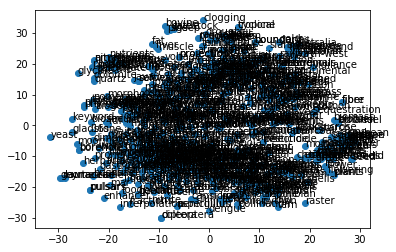

In [76]:
X = model[result_vocab]

font = matplotlib.font_manager.FontProperties(fname='./ipag.ttc')

words_np = []
#a list of labels (words)
words_label = []
for word, vector in result_vocab.items():
    words_np.append(model[word])
    words_label.append(word)
        
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, random_state=0)
numpy.set_printoptions(suppress=True)
Y = tsne.fit_transform(words_np)



In [88]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

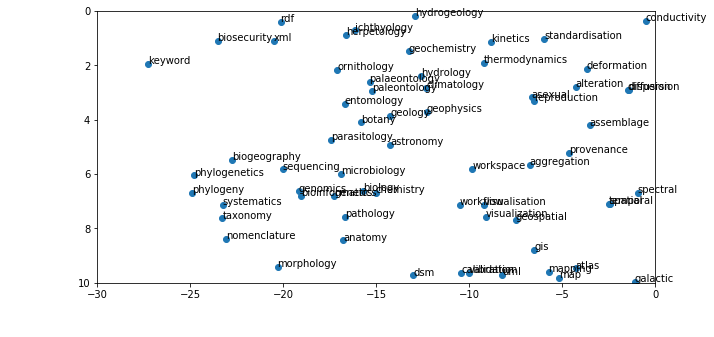

In [89]:
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(result_vocab.keys(), Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.ylim(10, 0)
plt.xlim(-30, 0)
plt.show()

## Suggesting new keywords

We could envisage a keyword tagging interface were we suggest new keywords based on the average distance from existing keywords

In [57]:
model.similar_by_vector((model['dog'] + model['cat'])/2,topn=10)

[('dog', 0.921538770198822),
 ('cat', 0.9122815728187561),
 ('dogs', 0.7285658121109009),
 ('pet', 0.6637269258499146),
 ('cats', 0.6461218595504761),
 ('puppy', 0.5556367635726929),
 ('horse', 0.5517184138298035),
 ('animal', 0.531834065914154),
 ('pets', 0.5269761085510254),
 ('hound', 0.5094276666641235)]

If you have tagged a data item with dog and cats maybe you also want to tag it with "animal" or "pets"

In [58]:
model.similar_by_vector((model['water'] + model['runoff'])/2,topn=30)

[('runoff', 0.8186976909637451),
 ('water', 0.8018253445625305),
 ('sewage', 0.5654644966125488),
 ('run-off', 0.546949565410614),
 ('groundwater', 0.5467579960823059),
 ('polluted', 0.5163611173629761),
 ('drainage', 0.515787661075592),
 ('irrigation', 0.5122992992401123),
 ('pollution', 0.5067722797393799),
 ('seawater', 0.4968295097351074),
 ('soil', 0.4866226017475128),
 ('drinking', 0.4837367534637451),
 ('waste', 0.4792274832725525),
 ('rainwater', 0.4654936194419861),
 ('moisture', 0.4654146730899811),
 ('reservoirs', 0.46503356099128723),
 ('rain', 0.46365755796432495),
 ('potable', 0.46122878789901733),
 ('rivers', 0.4577578902244568),
 ('reservoir', 0.45721039175987244),
 ('wastewater', 0.4544180631637573),
 ('waters', 0.4541703462600708),
 ('flooding', 0.44811367988586426),
 ('clean', 0.44566574692726135),
 ('rainfall', 0.43809616565704346),
 ('contaminated', 0.4357152581214905),
 ('flow', 0.4356193542480469),
 ('drain', 0.43446698784828186),
 ('contamination', 0.43237060308

In [59]:
model.similar_by_vector((model['solar'] + model['radiation'])/2,topn=10)

[('radiation', 0.8520972728729248),
 ('solar', 0.8336105346679688),
 ('ultraviolet', 0.6234352588653564),
 ('uv', 0.5582942962646484),
 ('infrared', 0.5512473583221436),
 ('thermal', 0.5436907410621643),
 ('cosmic', 0.5349714756011963),
 ('sunlight', 0.5338567495346069),
 ('emitted', 0.5294535756111145),
 ('electromagnetic', 0.5245305299758911)]

## Limitations of word2vec

There are apparently lots of relationships that aren't semantic but are more based on word proximity or spelling. Famously it is possible to use word2vec to find that the relation"man is related to king" applied to "woman" gives "queen"
It doesn't work so well with everything


In [60]:
model.similar_by_vector((model['woman'] + model['king'] - model['man']), topn=100)

[('king', 0.8065859079360962),
 ('queen', 0.6896163821220398),
 ('monarch', 0.5575490593910217),
 ('throne', 0.5565374493598938),
 ('princess', 0.5518684387207031),
 ('mother', 0.5142154097557068),
 ('daughter', 0.513315737247467),
 ('kingdom', 0.5025345087051392),
 ('prince', 0.5017740726470947),
 ('elizabeth', 0.4908031225204468),
 ('wife', 0.4840559959411621),
 ('crown', 0.4728339910507202),
 ('woman', 0.4675373435020447),
 ('her', 0.45041656494140625),
 ('royal', 0.4489114582538605),
 ('marry', 0.4381888508796692),
 ('married', 0.43084365129470825),
 ('sister', 0.42904388904571533),
 ('husband', 0.42386510968208313),
 ('ii', 0.4199441075325012),
 ('mary', 0.41993027925491333),
 ('duke', 0.41978520154953003),
 ('anne', 0.4154040217399597),
 ('regent', 0.41426482796669006),
 ('niece', 0.41178426146507263),
 ('marriage', 0.40905052423477173),
 ('margaret', 0.4079943299293518),
 ('she', 0.4075208306312561),
 ('emperor', 0.4063114523887634),
 ('duchess', 0.40345293283462524),
 ('widow',

In [61]:
model.most_similar(positive=['yellow', 'tomato'], negative=['red'])
#model.similar_by_vector(((model['yellow'] + model['strawberry'] - model['red']) + (model['yellow'] + model['tomato'] - model['red']))/2 , topn=100)

[('zucchini', 0.5701828002929688),
 ('eggplant', 0.5665943026542664),
 ('tomatoes', 0.5604736804962158),
 ('avocado', 0.5497550964355469),
 ('spinach', 0.5222511291503906),
 ('cucumber', 0.5068976283073425),
 ('lettuce', 0.4866516590118408),
 ('watermelon', 0.4849747121334076),
 ('onion', 0.48183757066726685),
 ('vegetable', 0.4807186722755432)]

In [62]:
model.similar_by_vector((model['water'] - model['salt']), topn=100)

[('water', 0.49908646941185),
 ('sanitation', 0.392291396856308),
 ('electricity', 0.3892342448234558),
 ('potable', 0.3729451894760132),
 ('sewage', 0.34720665216445923),
 ('emergency', 0.332465797662735),
 ('flood', 0.32895636558532715),
 ('drinking', 0.30943164229393005),
 ('irrigation', 0.3018989562988281),
 ('sewerage', 0.295976459980011),
 ('waters', 0.2916158437728882),
 ('supply', 0.29060104489326477),
 ('heaters', 0.28887104988098145),
 ('power', 0.288494348526001),
 ('forth', 0.2883579134941101),
 ('floodwaters', 0.28483453392982483),
 ('toilets', 0.2824137210845947),
 ('reservoir', 0.2806611657142639),
 ('shelter', 0.2799522578716278),
 ('inflatable', 0.2797348201274872),
 ('hose', 0.2758522629737854),
 ('fuel', 0.2753504514694214),
 ('hoses', 0.2748646140098572),
 ('sewer', 0.27269724011421204),
 ('supplies', 0.27109020948410034),
 ('boats', 0.26907333731651306),
 ('wastewater', 0.268878310918808),
 ('dams', 0.26764512062072754),
 ('dam', 0.26609787344932556),
 ('generators

In [68]:
colors = { 'tomato': 'red',
          'sky' : 'blue',
          'coal' : 'black',
          'sulfur' : 'yellow'         
         }
difference = None
for word1, word2 in colors.items():
    print(word1)
    print(word2)
    if difference is None:
        difference = (model[word1] - model[word2])
    else:
        difference += (model[word1] - model[word2])

difference /= len(colors)

model.similar_by_vector(difference,topn=100)

tomato
red
sky
blue
coal
black
sulfur
yellow


[('sulfur', 0.4082890748977661),
 ('biomass', 0.37060636281967163),
 ('methane', 0.3680614233016968),
 ('liquefaction', 0.36776357889175415),
 ('coal', 0.3645560145378113),
 ('revivifying', 0.3642549216747284),
 ('einsteinium', 0.35991495847702026),
 ('furnaces', 0.35524335503578186),
 ('dioxide', 0.3489069938659668),
 ('so2', 0.3484277129173279),
 ('feedstock', 0.3460592031478882),
 ('workover', 0.34195971488952637),
 ('nitrogen', 0.3403649926185608),
 ('2,615', 0.3397219479084015),
 ('rooper', 0.3366228938102722),
 ('pollutant', 0.3364943861961365),
 ('kaltim', 0.3359118700027466),
 ('vrbovec', 0.3354317843914032),
 ('by-product', 0.33457881212234497),
 ('coking', 0.33435937762260437),
 ('co2', 0.33394262194633484),
 ('over-population', 0.3335029184818268),
 ('smelters', 0.3328727185726166),
 ('llw', 0.3318973183631897),
 ('geosmin', 0.3318478465080261),
 ('inti', 0.33148398995399475),
 ('diammonium', 0.3310140371322632),
 ('petrochemistry', 0.32994911074638367),
 ('nonylphenol', 0.3

In [74]:
model.most_similar(positive=['yellow', 'bunch', 'fruit'], topn=100) 

[('fruits', 0.6204125285148621),
 ('flowers', 0.5955206155776978),
 ('bright', 0.5717793703079224),
 ('red', 0.570356011390686),
 ('berries', 0.5619615912437439),
 ('purple', 0.550870418548584),
 ('vegetables', 0.5429374575614929),
 ('orange', 0.5417463779449463),
 ('pink', 0.5412436723709106),
 ('green', 0.5293484926223755),
 ('flower', 0.5223943591117859),
 ('tomato', 0.5201548337936401),
 ('colored', 0.5142461061477661),
 ('juice', 0.5093603134155273),
 ('dried', 0.5090316534042358),
 ('apples', 0.5070767998695374),
 ('ripe', 0.49489259719848633),
 ('tomatoes', 0.49187809228897095),
 ('trees', 0.4913737177848816),
 ('beans', 0.4900389313697815),
 ('edible', 0.48981401324272156),
 ('colors', 0.4891403317451477),
 ('grapes', 0.48298153281211853),
 ('leaves', 0.4816040098667145),
 ('nuts', 0.48078590631484985),
 ('mushrooms', 0.47849369049072266),
 ('grape', 0.4782850444316864),
 ('blue', 0.47625142335891724),
 ('stuff', 0.47623932361602783),
 ('picking', 0.47455766797065735),
 ('varie

In [65]:
model.similar_by_vector(model['meters'] + model['tall'], topn=100) 

[('meters', 0.8691878318786621),
 ('tall', 0.8533526062965393),
 ('metres', 0.7684553265571594),
 ('feet', 0.7459859848022461),
 ('meter', 0.7151063680648804),
 ('height', 0.6292724013328552),
 ('metre', 0.6133023500442505),
 ('m', 0.6051520705223083),
 ('inches', 0.5688554048538208),
 ('centimeters', 0.5521728992462158),
 ('ft', 0.5430169105529785),
 ('foot', 0.5379891395568848),
 ('taller', 0.5375359058380127),
 ('centimetres', 0.5244764089584351),
 ('thick', 0.5189315676689148),
 ('diameter', 0.5047868490219116),
 ('cm', 0.5028142333030701),
 ('towering', 0.49395322799682617),
 ('above', 0.47632113099098206),
 ('tallest', 0.4680122137069702),
 ('6-foot', 0.46595123410224915),
 ('yards', 0.4580432176589966),
 ('stands', 0.4558824896812439),
 ('kilometers', 0.45539915561676025),
 ('10-foot', 0.4520391821861267),
 ('200', 0.44777730107307434),
 ('trees', 0.4474383592605591),
 ('jump', 0.44673773646354675),
 ('cubic', 0.4390564560890198),
 ('standing', 0.4371226131916046),
 ('20-foot', 

In [66]:
# what is the direction to move in to be the opposite of hot?
# a fire without its heat must move in the direction of "cold"
# 
model.similar_by_vector(model['fire'] - model['hot'])

[('fire', 0.5652563571929932),
 ('cease', 0.390556275844574),
 ('firing', 0.3865264058113098),
 ('gunfire', 0.3802269399166107),
 ('fires', 0.3728276789188385),
 ('gunmen', 0.357028603553772),
 ('fired', 0.3469422459602356),
 ('destroyed', 0.3426634967327118),
 ('explosions', 0.3339660167694092),
 ('civilians', 0.333923876285553)]